In [2]:
from clean_data_load import *

Script: 01.01.02 [Import Packages] completed
Script: 01.01.03 [Update Data Paths] completed
Script: 01.01.04 [Define Other Global Variables] completed
Script: 01.01.05 [Define Functions] completed
Script: 05.00.02 [Import Packages] completed
Script: 05.01.01 [Load Cleaned Product Data] completed
Script: 05.02.01 [Load One Hot Encoded Product Data] completed


In [3]:
from environment_configuration import *

# Import packages
import pickle
import pandas as pd
from pathlib import Path
import gc
pd.set_option('display.max_rows', 500)

In [5]:
products_prep = products_clean[['asin', 'price_t', 'numberQuestions','numberReviews','meanStarRating']]
#products_prep.head()
cats = products_clean.category2_t+"-"+products_clean.category3_t
products_prep.loc[:,'Category_'] = cats
cats_df = pd.DataFrame(cats.value_counts(), columns=['Count'])
cats_df.reset_index(inplace=True)
cats_df['cat_idx'] = cats_df.index + 1
cats_df.rename(columns={"index": "Category_"}, inplace=True)
#products_prep.loc[:,'cat_idx'] = cats_df.cat_idx
#products_prep.head()
prod_df = pd.merge(products_prep, cats_df[['Category_','cat_idx']], how='inner', on='Category_').drop(columns=['Category_'])

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import datetime, os
#tf.reset_default_graph()
from tensorflow.keras import backend as K

In [7]:
prod_df.set_index('asin', inplace=True)

In [27]:
# input_dim: int > 0. Size of the vocabulary, i.e. maximum integer index + 1.
# output_dim: int >= 0. Dimension of the dense embedding.
# input_length: Length of input sequences, when it is constant. 

#clear prior session before running
K.clear_session()

num_prods, prod_cols = prod_df.shape
item_input = layers.Input(shape=(prod_cols,), name = 'item')
"""
# Include RELU as activation layer
encode = layers.Dense(25, activation='relu',name="Dense_1e")(item_input)
#encode = layers.Dropout(0.25, name="Dropout_1e")(encode)
encode = layers.Dense(50, activation='relu',name="Dense_2e")(encode)
#encode = layers.Dropout(0.1, name="Dropout_2e")(encode)
encode = layers.Dense(75, activation='relu',name="Dense_3e")(encode)
#encode = layers.Dropout(0.05, name="Dropout_3e")(encode)
"""

#starting at 100
embedding_size = 100
item_embedding = layers.Embedding(output_dim = embedding_size, input_dim = num_prods,
                           input_length = prod_cols, name = 'item_embedding')(item_input)

"""
encode = layers.Dense(100, activation='relu',name="Dense_4e")(encode)
"""

decode = layers.Flatten(name="Flatten_User")(item_embedding)
# Include RELU as activation layer
decode = layers.Dense(75, activation='relu',name="Dense_1d")(decode)
#decode = layers.Dropout(0.05, name="Dropout_1d")(decode)
decode = layers.Dense(50, activation='relu',name="Dense_2d")(decode)
#decode = layers.Dropout(0.05, name="Dropout_2d")(decode)
decode = layers.Dense(25, activation='relu',name="Dense_3d")(decode)
#decode = layers.Dropout(0.05, name="Dropout_3d")(decode)
y = layers.Dense(prod_cols, activation='relu', name="output")(decode)# * 5 + 0.5 #scale to 1-5

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model = keras.models.Model(inputs=item_input, outputs=y)
model.compile(optimizer='adam', loss='mae', metrics=[r2_keras])

#add tensorboard
#log_dir="logs/fit/recsys_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join(
    "logs",
    "fit",
    "autoencoder_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
)
print(log_dir)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

logs\fit\autoencoder_20191109-223058


In [28]:
# input user_id_train & item_id_train
# output rating_train
history = model.fit([prod_df.astype(float).values], prod_df.astype(float).values,
                    batch_size=256, epochs=30, validation_split=0.1,
                    shuffle=True,callbacks=[tensorboard_callback])

Train on 56691 samples, validate on 6299 samples
Epoch 1/30
56691/56691 [==============================] - 15s 272us/sample - loss: 13.6909 - r2_keras: 0.1461 - val_loss: 22.7212 - val_r2_keras: 0.3049
Epoch 2/30
56691/56691 [==============================] - 14s 252us/sample - loss: 4.3918 - r2_keras: 0.5580 - val_loss: 15.1849 - val_r2_keras: 0.5760
Epoch 3/30
56691/56691 [==============================] - 14s 244us/sample - loss: 2.7209 - r2_keras: 0.7089 - val_loss: 11.9668 - val_r2_keras: 0.6897
Epoch 4/30
56691/56691 [==============================] - 14s 247us/sample - loss: 2.0328 - r2_keras: 0.7796 - val_loss: 9.9478 - val_r2_keras: 0.7541
Epoch 5/30
56691/56691 [==============================] - 14s 247us/sample - loss: 1.6411 - r2_keras: 0.8317 - val_loss: 8.6945 - val_r2_keras: 0.7931
Epoch 6/30
56691/56691 [==============================] - 14s 246us/sample - loss: 1.3812 - r2_keras: 0.8598 - val_loss: 8.0271 - val_r2_keras: 0.8177
Epoch 7/30
56691/56691 [=================

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
item (InputLayer)            [(None, 5)]               0         
_________________________________________________________________
item_embedding (Embedding)   (None, 5, 100)            6299000   
_________________________________________________________________
Flatten_User (Flatten)       (None, 500)               0         
_________________________________________________________________
Dense_1d (Dense)             (None, 75)                37575     
_________________________________________________________________
Dense_2d (Dense)             (None, 50)                3800      
_________________________________________________________________
Dense_3d (Dense)             (None, 25)                1275      
_________________________________________________________________
output (Dense)               (None, 5)                 130   

In [30]:
model.predict(prod_df.iloc[0].astype(float).values.reshape(1,-1)).round(2)

array([[299.64,  -0.  ,   5.53,   2.49,  42.51]], dtype=float32)

In [119]:
prod_df.iloc[0].astype(float)

price_t            299.99
numberQuestions      0.00
numberReviews        5.00
meanStarRating       2.40
cat_idx             44.00
Name: 0528881469, dtype: float64

In [18]:
# weights and shape
weights = model.get_weights()
[w.shape for w in weights]

[(62990, 100),
 (500, 75),
 (75,),
 (75, 50),
 (50,),
 (50, 25),
 (25,),
 (25, 5),
 (5,)]

In [35]:
item_embeddings = weights[0]
print("First item name from metadata:", products_prep.loc[0])
print("Embedding vector for the first item:")
print(item_embeddings[0])
print("shape:", item_embeddings[0].shape)

First item name from metadata: asin                                 0528881469
price_t                                  299.99
numberQuestions                               0
numberReviews                                 5
meanStarRating                              2.4
Category_          GPS & Navigation-Vehicle GPS
Name: 0, dtype: object
Embedding vector for the first item:
[-0.17060068 -0.2043758   0.19147606  0.01245133 -0.03259962 -0.06112105
  0.00149503 -0.00702849 -0.06438332  0.05072632  0.12058453 -0.0685692
 -0.10002546  0.18551214  0.05179593 -0.05372452  0.11705261 -0.0306901
 -0.19113186 -0.04084791  0.06822552  0.00118403 -0.05641241  0.05893859
 -0.13199452 -0.13706657  0.0558959  -0.05926238  0.05286935  0.00708205
  0.01471874 -0.03844082  0.13180207 -0.15887658  0.1238729   0.01134666
  0.00593501 -0.15740305  0.16123387 -0.2140405   0.0792003   0.11761726
 -0.0842109  -0.01070219  0.22099051 -0.07729842  0.11194171  0.05230936
 -0.06252626  0.05910843 -0.15450783 -0

In [39]:
import scipy.spatial.distance
def cos_cdist(matrix, vector):
    """
    Compute the cosine distances between each row of matrix and vector.
    """
    v = vector.reshape(1, -1)
    return 1-scipy.spatial.distance.cdist(matrix, v, 'cosine').reshape(-1)

In [56]:
x = item_embeddings[6]
y = cos_cdist(item_embeddings, x)

In [57]:
len(y)

62990

In [58]:
sim_results = pd.DataFrame(y, columns=['cdist'])

In [59]:
sim_results.nlargest(10, 'cdist').round(6)

,cdist
6,1.000000
7,0.882292
8,0.849195
9,0.791063
13,0.774677
2,0.764839
3,0.746783
15,0.741359
4,0.739367
12,0.716959


In [70]:
products_prep.loc[2]

asin                                               0594481813
price_t                                                 19.65
numberQuestions                                             0
numberReviews                                               8
meanStarRating                                              4
Category_          eBook Readers & Accessories-Power Adapters
Name: 2, dtype: object

In [72]:
cats_df.head()

,Category_,Count,cat_idx
0,Computers & Accessories-Cables & Accessories,7483,1
1,Accessories & Supplies-Audio & Video Accessories,7283,2
2,Camera & Photo-Accessories,4850,3
3,Computers & Accessories-Touch Screen Tablet Ac...,4148,4
4,Computers & Accessories-Computer Components,4097,5


In [73]:
from sklearn.manifold import TSNE
item_tsne = TSNE(perplexity=30).fit_transform(item_embeddings)

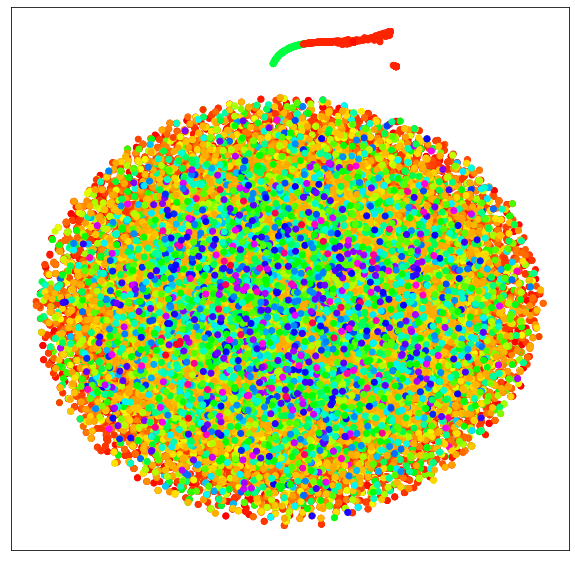

In [91]:
import matplotlib.pyplot as plt
import numpy as np
hsv = plt.get_cmap('hsv')
colors = hsv(np.linspace(0, 1.0, len(cats_df)))
color_cats = prod_df.cat_idx-1
plt.figure(figsize=(10, 10))
plt.scatter(item_tsne[:, 0], item_tsne[:, 1],
           c=colors[color_cats])
plt.xticks(()); plt.yticks(())
plt.show()